### This graphic shows the utilization of Pittsburgh Regional Transit by route
##### ERL67@pitt.edu
##### Data Source: [PRT Monthly Average Ridership by Route](https://data.wprdc.org/dataset/prt-monthly-average-ridership-by-route)

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

%matplotlib inline

# https://data.wprdc.org/dataset/prt-monthly-average-ridership-by-route
data = pd.read_csv('12bb84ed-397e-435c-8d1b-8ce543108698.csv')

# View the first few rows of the dataset
data.head(3), data.columns

(   _id route ridership_route_code    route_full_name current_garage mode  \
 0    1     1                  001  1 - FREEPORT ROAD           Ross  Bus   
 1    2     4                  004      4 - TROY HILL           Ross  Bus   
 2    3     6                  006    6 - SPRING HILL           Ross  Bus   
 
   month_start  year_month day_type  avg_riders  day_count  
 0  2017-01-01      201701     SAT.      969.50          4  
 1  2017-01-01      201701     SAT.      218.25          4  
 2  2017-01-01      201701     SAT.      495.50          4  ,
 Index(['_id', 'route', 'ridership_route_code', 'route_full_name',
        'current_garage', 'mode', 'month_start', 'year_month', 'day_type',
        'avg_riders', 'day_count'],
       dtype='object'))

In [151]:
# Summary statistics for average riders
print(data['avg_riders'].describe())

# Total riders per transit mode
mode_summary = data.groupby('mode')['avg_riders'].sum().reset_index()
print(mode_summary)

count    22317.000000
mean      1189.182466
std       1394.175838
min         -1.954545
25%        340.750000
50%        727.238095
75%       1486.000000
max      11510.250000
Name: avg_riders, dtype: float64
         mode    avg_riders
0         Bus  2.281862e+07
1     Incline  3.324947e+05
2  Light Rail  8.115560e+05
3        Rail  2.576082e+06


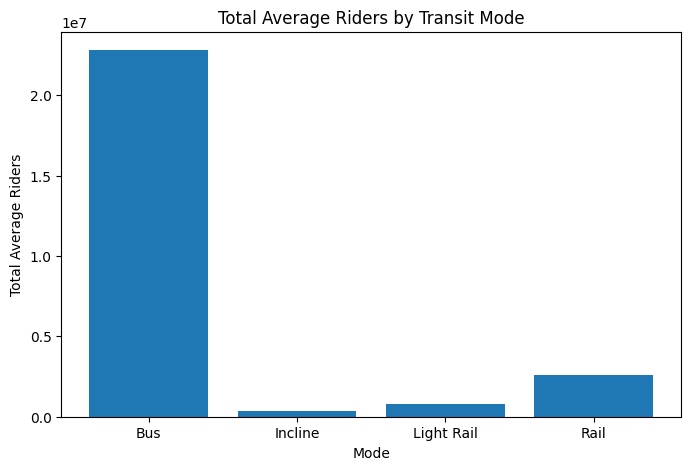

In [152]:
# Bar plot of average riders by mode
plt.figure(figsize=(8, 5))
plt.bar(mode_summary['mode'], mode_summary['avg_riders'])
plt.title('Total Average Riders by Transit Mode')
plt.xlabel('Mode')
plt.ylabel('Total Average Riders')
plt.show()

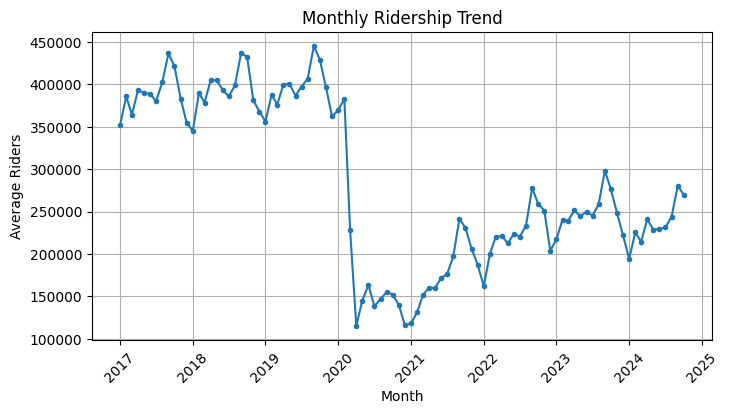

In [153]:
# Convert 'month_start' to datetime for plotting
data['month_start'] = pd.to_datetime(data['month_start'])

# Group data by month to get total average riders
monthly_ridership = data.groupby('month_start')['avg_riders'].sum().reset_index()

# Line plot of ridership over time
plt.figure(figsize=(8, 4))
plt.plot(monthly_ridership['month_start'], monthly_ridership['avg_riders'], marker='.')
plt.title('Monthly Ridership Trend')
plt.xlabel('Month')
plt.ylabel('Average Riders')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('monthly_ridership_trend.png', dpi=300, bbox_inches='tight')
plt.show()

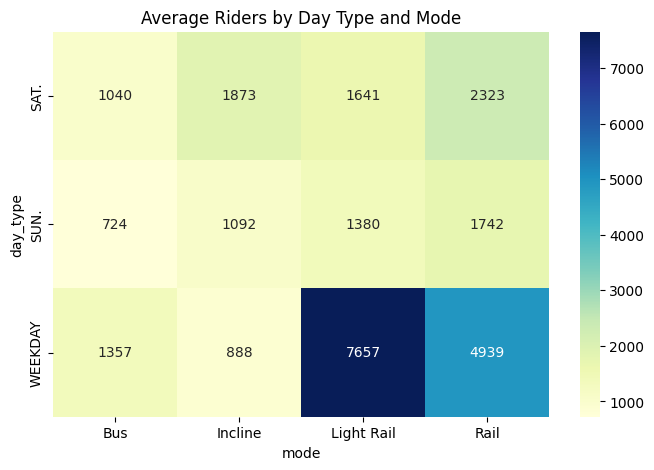

In [154]:
# Pivot table for heatmap
pivot = data.pivot_table(values='avg_riders', index='day_type', columns='mode', aggfunc='mean')

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".0f")
plt.title('Average Riders by Day Type and Mode')
plt.show()

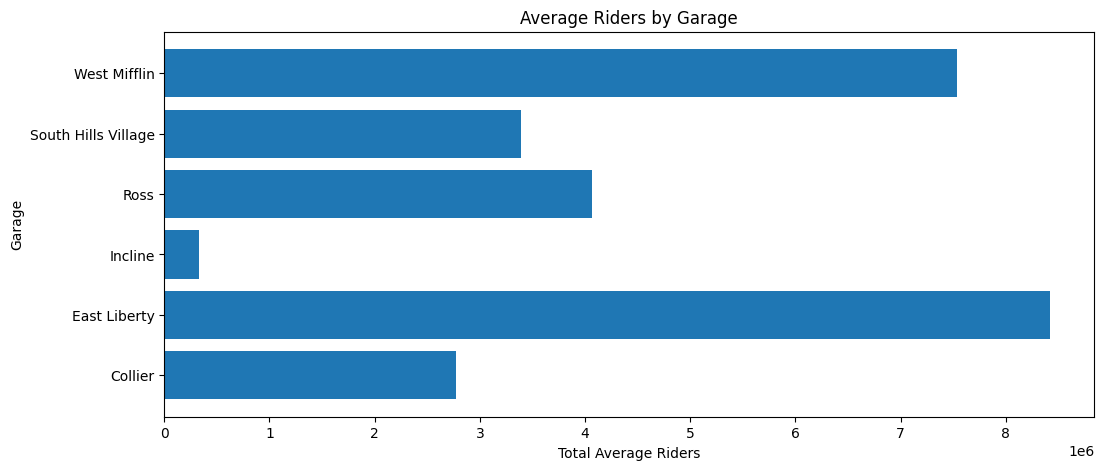

In [155]:
# Group by garage and sum the riders
garage_ridership = data.groupby('current_garage')['avg_riders'].sum().reset_index()

# Bar plot of riders by garage
plt.figure(figsize=(12, 5))
plt.barh(garage_ridership['current_garage'], garage_ridership['avg_riders'])
plt.title('Average Riders by Garage')
plt.xlabel('Total Average Riders')
plt.ylabel('Garage')
plt.show()

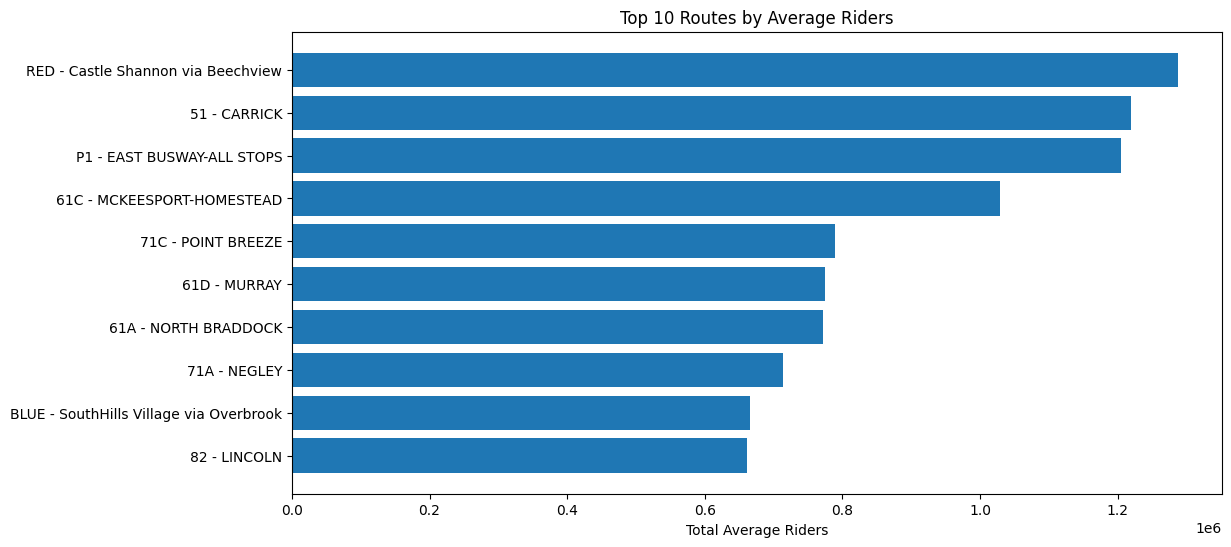

In [156]:
# Group by route and get the total riders
route_ridership = data.groupby('route_full_name')['avg_riders'].sum().reset_index()

# Sort by total riders and plot top 10 routes
top_routes = route_ridership.sort_values(by='avg_riders', ascending=False).head(10)

# Bar plot for top 10 routes
plt.figure(figsize=(12, 6))
plt.barh(top_routes['route_full_name'], top_routes['avg_riders'])
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title('Top 10 Routes by Average Riders')
plt.xlabel('Total Average Riders')
plt.show()

In [157]:
# Group by day_type and calculate the mean and variance
day_type_stats = data.groupby('day_type')['avg_riders'].agg(['mean', 'var']).reset_index()
print(day_type_stats)

  day_type         mean           var
0     SAT.  1112.618227  1.159557e+06
1     SUN.   782.783580  5.871116e+05
2  WEEKDAY  1513.216543  3.176469e+06


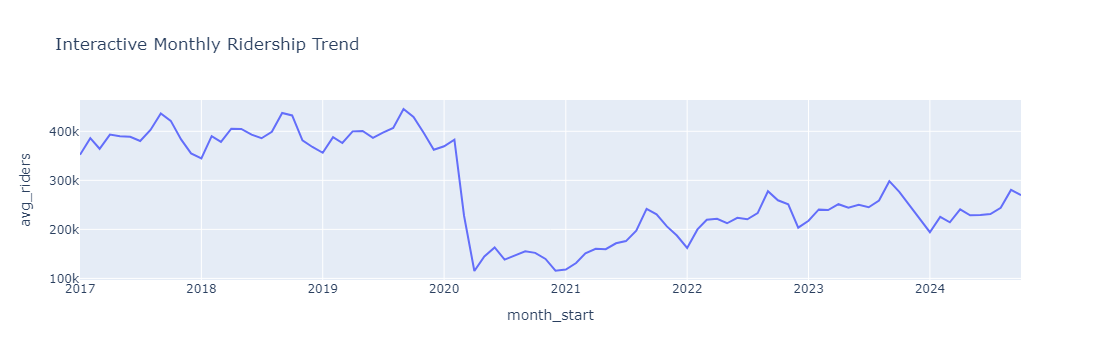

In [158]:
# Interactive line plot with Plotly
fig = px.line(monthly_ridership, x='month_start', y='avg_riders', 
              title='Interactive Monthly Ridership Trend')
fig.show()

### This is the final product

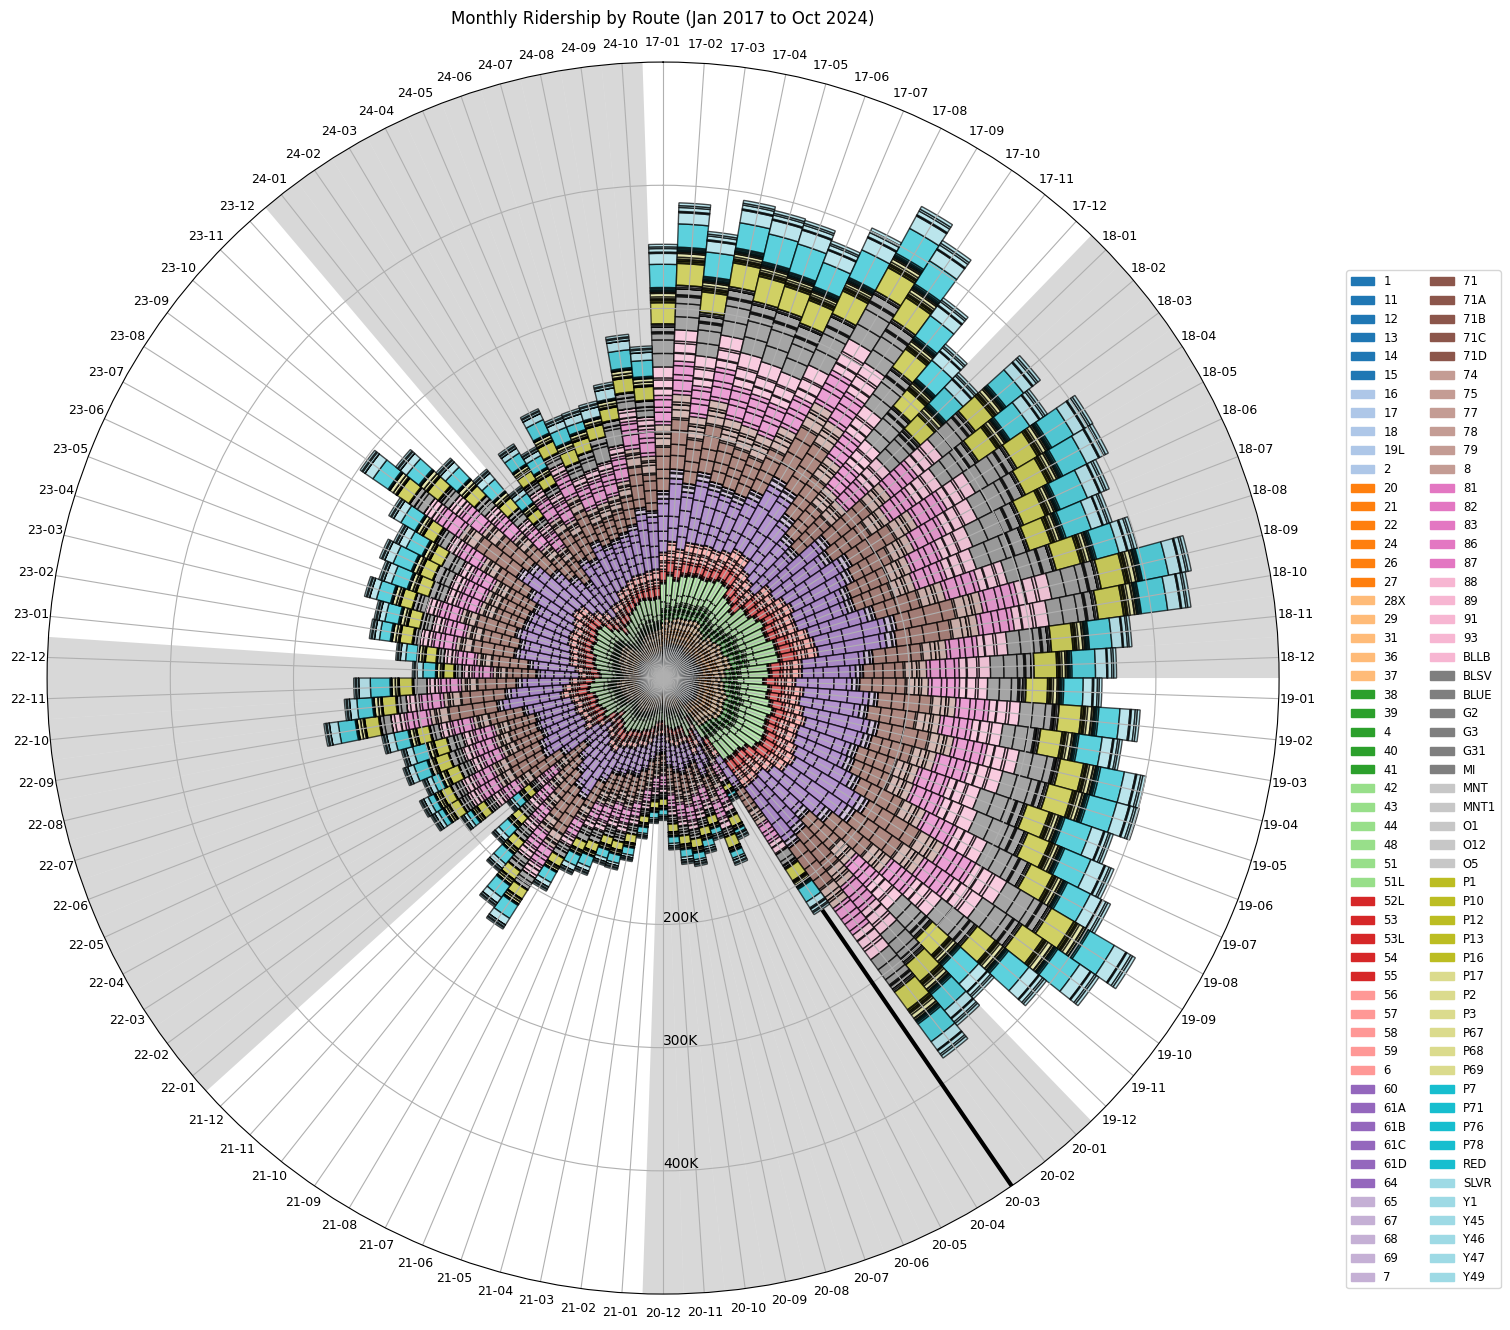

In [160]:
# Convert the 'month_start' column to datetime for filtering and grouping
data['month_start'] = pd.to_datetime(data['month_start'])

# Filter the data from January 2017 onwards
filtered_data = data[data['month_start'] >= '2017-01-01']

# Group the data by year-month and route, summing the average riders
monthly_ridership = filtered_data.groupby(
    [filtered_data['month_start'].dt.to_period('M'), 'route']
)['avg_riders'].sum().reset_index()

# Create a unique month-year identifier with the format YY-MM
monthly_ridership['month_year'] = monthly_ridership['month_start'].dt.strftime('%y-%m')

# Pivot the data to create a matrix where each row is a month and each column is a route
pivot_data = monthly_ridership.pivot_table(
    index='month_year', columns='route', values='avg_riders', fill_value=0
)

# Adding alternating background colors for entire pie slices (from center to edge)
fig, ax = plt.subplots(figsize=(16, 16), subplot_kw={'projection': 'polar'})

# Set radius explicitly
ax.set_ylim(0, 500000)  # Set the radial limits from 0 to 500,000


# Define angles and bar width
num_months = len(pivot_data)
angles = np.linspace(0, 2 * np.pi, num_months, endpoint=False).tolist()
width = 2 * np.pi / num_months

# Generate color map for routes
colors = plt.cm.tab20(np.linspace(0, 1, pivot_data.shape[1]))

# Plot the alternating background for years as full slices
for idx, month in enumerate(pivot_data.index):
    year = month.split('-')[0]  # Extract year (YY format)
    if int(year) % 2 == 0:  # Even years get light gray
        ax.bar(
            angles[idx], 500000, width=width, color='gray', edgecolor=None, alpha=0.3
        )

# Plot each month as a stacked bar in polar coordinates
for idx, (month, row) in enumerate(pivot_data.iterrows()):
    bottom = 0
    for i, value in enumerate(row):
        ax.bar(
            angles[idx], value, width=width, bottom=bottom, color=colors[i], edgecolor='black', alpha=0.7
        )
        bottom += value

# Highlight the radial line for 20-03 in dark thick black
highlight_month = '20-03'
highlight_angle = angles[pivot_data.index.get_loc(highlight_month)]  # Find the angle for 20-03

# Adding a thicker line for 20-03 to indicate start of covid
ax.plot(
    [highlight_angle, highlight_angle],  # Angle for the line
    [230000, 500000],  # From the center to the outer edge
    color='black', linewidth=3, zorder=3  # Dark thick black line
)

# Add labels for each month-year with radial alignment
ax.set_xticks(angles)
ax.set_xticklabels(
    pivot_data.index, fontsize=9, ha='center', va='center', rotation_mode='anchor'
)

# Rotate the labels along the radial axis
for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_rotation(np.degrees(angle) + 90)  # Rotate 90 degrees for radial alignment

# Set the starting location to 0 degrees (with 17-01 at the top)
ax.set_theta_zero_location('N')  # 'N' means north, i.e., 0 degrees at the top

# Set the direction to clockwise
ax.set_theta_direction(-1)  # -1 sets the direction to clockwise

# Move the radial tick labels to align with the 2020-11 radii
target_angle = angles[pivot_data.index.get_loc('20-12')]  # Angle for 2020-12
ax.set_rlabel_position(np.degrees(target_angle))  # Align radial tick labels to this angle

# Customize the radial ticks to exclude 10,000
ax.set_yticks([200000, 300000, 400000])  # Only include these tick values
ax.set_yticklabels(['200K', '300K', '400K'], fontsize=10)  # Format the labels

# Add a title
plt.title('Monthly Ridership by Route (Jan 2017 to Oct 2024)', va='bottom')

# Display a two-column legend for route colors
ax.legend(
    [plt.Rectangle((0, 0), 1, 1, color=c) for c in colors],
    pivot_data.columns,
    # loc='center left', 
    # bbox_to_anchor=(1.1, 0.5),
    loc='lower left', 
    bbox_to_anchor=(1.05, 0),
    fontsize='small',
    ncol=2
)

# Show and save the plot
plt.savefig('monthly_ridership_circular_plot.png', dpi=300, bbox_inches='tight')
plt.show()

##### This is an experimental version of an interactive version of the chart above
##### I filtered the data to start with June 2018 so it's less cluttered

In [162]:
# Convert the 'month_start' column to datetime for filtering and grouping
data['month_start'] = pd.to_datetime(data['month_start'])

# Filter the data from January 2017 onwards
filtered_data = data[data['month_start'] >= '2018-06-01']

# Group the data by year-month and route, summing the average riders
monthly_ridership = filtered_data.groupby(
    [filtered_data['month_start'].dt.to_period('M'), 'route']
)['avg_riders'].sum().reset_index()

# Create a unique month-year identifier with the format YY-MM
monthly_ridership['month_year'] = monthly_ridership['month_start'].dt.strftime('%y-%m')

# Pivot the data to create a matrix where each row is a month and each column is a route
pivot_data = monthly_ridership.pivot_table(
    index='month_year', columns='route', values='avg_riders', fill_value=0
)

# Rotate data so 17-01 is the first entry
pivot_data = pd.concat([pivot_data.loc["17-01":], pivot_data.loc[:"17-01"]])

# Define angles and bar width for the polar plot
num_months = len(pivot_data)
angles = np.linspace(0, 360, num_months, endpoint=False).tolist()  # Regular angles

# Create a Plotly figure
fig = go.Figure()

# Add each route as a separate bar layer
for idx, route in enumerate(pivot_data.columns):
    fig.add_trace(go.Barpolar(
        r=pivot_data[route],  # Ridership values for this route
        theta=angles,  # Correctly oriented angles
        width=360 / num_months,  # Bar width in degrees
        name=f"{route}",  # Only display the route number
        marker_color=f"rgba{plt.cm.tab20(idx / len(pivot_data.columns))}",  # Use colormap
        hoverinfo="text",  # Enable hover text
        text=[
            f"Route: {route}<br>Month-Year: {month}<br>Total Ridership: {int(value)}"
            for month, value in zip(pivot_data.index, pivot_data[route])
        ]  # Custom hover text for each bar segment
    ))

# Find the angle for 2020-11 to set 100K labels
# target_angle = angles[pivot_data.index.get_loc('20-11')]

# Update the layout
fig.update_layout(
    title="Monthly Ridership by Route (June 2018 to October 2024)",
    width=1000,  # Width in pixels
    height=1000,  # Height in pixels
    polar=dict(
        angularaxis=dict(
            tickmode="array",
            tickvals=angles,  # Set ticks to match angles
            ticktext=pivot_data.index,  # Use Month-Year as tick labels
            rotation=90,  # Rotate angular ticks for better alignment
            direction="clockwise",  # Ensure clockwise tick arrangement
            tickfont=dict(size=8),  # Adjust font size for outer labels
        ),
        radialaxis=dict(
            range=[0, 500000],  # Set radial range
            tickvals=[100000, 200000, 300000, 400000, 500000],  # Radial tick values
            ticktext=["100K", "200K", "300K", "400K", "500K"],  # Radial tick labels
            showticklabels=False  # Move radial labels to the bottom
        )
    ),
    showlegend=False,
    legend=dict(
        title="Routes",  # Title for the legend
        orientation="h",  # Horizontal orientation
        yanchor="bottom",
        y=-0.2,  # Adjust position below the chart
        xanchor="center",
        x=0.5,
        font=dict(size=6),
        traceorder="normal",  # Maintain normal clockwise order
        itemwidth=60  # Space items evenly for two columns
    )
)

# Add custom annotations for radial tick labels at the bottom, not working
# radial_labels = ["100K", "200K", "300K", "400K", "500K"]
# for i, label in enumerate(radial_labels):
#     fig.add_annotation(
#         x=0.5,  # Center align the annotations
#         y=0.15 - (i * 0.05),  # Position below the chart with increasing offset
#         text=label,
#         showarrow=False,
#         font=dict(size=10),
#         xref="paper",
#         yref="paper"
#     )


# Show the interactive plot
fig.show()